<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [131]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7, input_shape=(100,)))
    model.add(layers.Dense(14*14,activation='relu'))
    model.add(layers.Dense(28*28,activation='sigmoid'))
    model.add(layers.Reshape((28,28,1)))

    return model

def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    x = layers.Conv2D(64,3,2,padding='same')(input_img)

    x = layers.Flatten()(x)

    dense_output = layers.Dense(128, activation='relu')(x)

    dense_output = layers.Dense(64, activation='relu')(x)

    dense_output = layers.Dense(1, activation='linear')(dense_output)

    model = tf.keras.models.Model(inputs=input_img, outputs=dense_output)
    return model

In [135]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0004)

In [136]:
BATCH_SIZE = 10

#@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

#@tf.function
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

#@tf.function
def gradient_penalty(real_images, fake_images):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminator(interpolated_images, training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [137]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        gp = gradient_penalty(images, generated_images)
        disc_loss += gp * GP_WEIGHT
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)

In [138]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]


            train_step(target_images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [ ]:
EPOCHS = 10
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2, EPOCHS)

disc_loss 6.19548798 gen_loss 0.00536694517
disc_loss 4.44998932 gen_loss 0.794716358
disc_loss 2.81679821 gen_loss 1.48987556
disc_loss 0.648393869 gen_loss 2.1395359
disc_loss -0.970346451 gen_loss 2.83594441
disc_loss -1.97498667 gen_loss 3.52835608
disc_loss -3.63129473 gen_loss 4.28111887
disc_loss -5.40681553 gen_loss 5.04475451
disc_loss -5.56603622 gen_loss 5.799891
disc_loss -5.66479 gen_loss 6.46719503
disc_loss -5.70435047 gen_loss 7.14926386
disc_loss -6.35442 gen_loss 7.97894382
disc_loss -6.43544292 gen_loss 8.80826378
disc_loss -7.66492653 gen_loss 9.582201
disc_loss -8.00772095 gen_loss 10.0660801
disc_loss -8.63428879 gen_loss 10.6993799
disc_loss -9.65016365 gen_loss 11.209281
disc_loss -9.82804871 gen_loss 11.6489029
disc_loss -10.3520927 gen_loss 12.454
disc_loss -10.300374 gen_loss 12.6810474
disc_loss -10.7863579 gen_loss 13.2805233
disc_loss -11.1656532 gen_loss 13.7350597
disc_loss -10.3760147 gen_loss 13.8227844
disc_loss -11.4525986 gen_loss 14.2384357
disc_lo

1/1 [==============================] - 0s 73ms/step


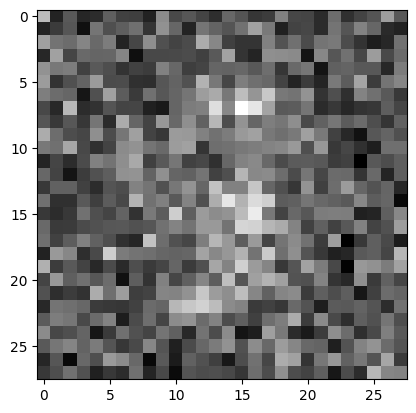

In [134]:
noise = tf.random.normal(shape=(10,100))
test = generator.predict(noise)
plt.imshow(test[1].squeeze(), cmap='gray')
plt.show()

In [113]:
print(np.min(x_train2))

0
